# EDA COMPLETO - ISIC 2018 (Train + Validation + Test)

## Objetivos:
1. Analizar distribución y características de los 3 conjuntos
2. Verificar consistencia entre imágenes y máscaras
3. Identificar potenciales problemas para el preprocesamiento


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from pathlib import Path
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
# Configurar rutas
BASE_PATH = Path("../data/raw")

DATASETS = {
    "train": {
        "images": BASE_PATH / "isic_2018_train/images",
        "masks": BASE_PATH / "isic_2018_train/masks"
    },
    "val": {
        "images": BASE_PATH / "isic_2018_val/images",
        "masks": BASE_PATH / "isic_2018_val/masks"
    },
    "test": {
        "images": BASE_PATH / "isic_2018_test/images",
        "masks": BASE_PATH / "isic_2018_test/masks",
    }
}

print("Verificando estructura de directorios...")
for name, paths in DATASETS.items():
    print(f"\n{name.upper()}:")
    print(f"  Imágenes: {paths['images'].exists()} ({len(list(paths['images'].glob('*.jpg')))} archivos)")
    print(f"  Máscaras: {paths['masks'].exists()} ({len(list(paths['masks'].glob('*.png')))} archivos)")

Verificando estructura de directorios...

TRAIN:
  Imágenes: True (2594 archivos)
  Máscaras: True (2594 archivos)

VAL:
  Imágenes: True (100 archivos)
  Máscaras: True (100 archivos)

TEST:
  Imágenes: True (1000 archivos)
  Máscaras: True (1000 archivos)


## 1. ANÁLISIS COMPARATIVO ENTRE CONJUNTOS

In [3]:
def get_dataset_stats(dataset_name, dataset_paths):
    """Obtiene estadísticas de un conjunto de datos"""
    
    stats = {
        "name": dataset_name,
        "total_images": 0,
        "total_masks": 0,
        "heights": [],
        "widths": [],
        "channels": [],
        "image_sizes_mb": [],
        "mask_sizes_mb": [],
        "pixel_intensity_means": [],
        "mask_coverage": []  # Solo para conjuntos con máscaras
    }
    
    # Analizar imágenes
    image_files = list(dataset_paths['images'].glob("*.jpg"))
    stats["total_images"] = len(image_files)
    
    # Muestrear para análisis intensivo
    
    for img_path in image_files:
        # Estadísticas de imagen
        img = cv2.imread(str(img_path))
        if img is not None:
            h, w, c = img.shape
            stats["heights"].append(h)
            stats["widths"].append(w)
            stats["channels"].append(c)
            stats["image_sizes_mb"].append(os.path.getsize(img_path) / (1024*1024))
            
            # Intensidad media de píxeles
            stats["pixel_intensity_means"].append(img.mean())
    
    # Analizar máscaras si existen
    if dataset_paths['masks']:
        mask_files = list(dataset_paths['masks'].glob("*.png"))
        stats["total_masks"] = len(mask_files)
        
        for mask_path in mask_files[:min(len(image_files), len(mask_files))]:
            mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
            stats["mask_sizes_mb"].append(os.path.getsize(mask_path) / (1024*1024))
                
            # Calcular cobertura (porcentaje de píxeles de lesión)
            mask_normalized = mask / 255.0 if mask.max() > 1 else mask
            coverage = mask_normalized.sum() / mask_normalized.size
            stats["mask_coverage"].append(coverage)
    
    return stats

In [4]:
# Calcular estadísticas para los 3 conjuntos
print("Calculando estadísticas...")
all_stats = {}

for name, paths in DATASETS.items():
    print(f"  Analizando {name}...")
    all_stats[name] = get_dataset_stats(name, paths)

Calculando estadísticas...
  Analizando train...
  Analizando val...
  Analizando test...


In [5]:
# Crear DataFrame comparativo
comparison_data = []

for name, stats in all_stats.items():
    comparison_data.append({
        "Dataset": name.upper(),
        "Imágenes": stats["total_images"],
        "Máscaras": stats["total_masks"],
        "Altura Media": np.mean(stats["heights"]) if stats["heights"] else 0,
        "Ancho Medio": np.mean(stats["widths"]) if stats["widths"] else 0,
        "Tamaño Img (MB)": np.mean(stats["image_sizes_mb"]) if stats["image_sizes_mb"] else 0,
        "Intensidad Media": np.mean(stats["pixel_intensity_means"]) if stats["pixel_intensity_means"] else 0,
        "Cobertura Media": np.mean(stats["mask_coverage"]) if stats["mask_coverage"] else 0,
    })

df_comparison = pd.DataFrame(comparison_data)
print("\nRESUMEN COMPARATIVO:")
display(df_comparison)


RESUMEN COMPARATIVO:


Dataset  Imágenes  Máscaras  Altura Media  Ancho Medio  Tamaño Img (MB)  \
0   TRAIN      2594      2594   2166.791442  3188.266384         4.123502   
1     VAL       100       100   1775.800000  2448.830000         2.286265   
2    TEST      1000      1000   1850.575000  2529.909000         2.264578   

   Intensidad Media  Cobertura Media  
0        155.261986         0.214021  
1        148.360084         0.268481  
2        148.102759         0.279850

## 2. VISUALIZACIÓN COMPARATIVA

In [6]:
# Figura 1: Distribución de dimensiones
fig1 = make_subplots( rows=1, cols=2, subplot_titles=("Distribución de Alturas", "Distribución de Anchuras") )

colors = {'train': 'blue', 'val': 'green', 'test': 'red'}

for name, stats in all_stats.items(): 
    if stats["heights"]: 
        fig1.add_trace( go.Histogram(x=stats["heights"], name=f"{name.upper()}", marker_color=colors[name], opacity=0.7), row=1, col=1 )
    fig1.add_trace( go.Histogram(x=stats["widths"], name=f"{name.upper()}", marker_color=colors[name], opacity=0.7, showlegend=False), row=1, col=2 ) 
fig1.update_layout(title_text="Comparación de Dimensiones entre Conjuntos", barmode='overlay') 
fig1.show()

In [7]:
# Análisis detallado de dimensiones y relación de aspecto
dimension_analysis = []

for name, stats in all_stats.items():
    if stats["heights"] and stats["widths"]:
        heights = np.array(stats["heights"])
        widths = np.array(stats["widths"])
        aspect_ratios = widths / heights
        
        dimension_analysis.append({
            "Dataset": name.upper(),
            "Altura Mín": heights.min(),
            "Altura Máx": heights.max(),
            "Altura Media": heights.mean(),
            "Altura Std": heights.std(),
            "Ancho Mín": widths.min(),
            "Ancho Máx": widths.max(),
            "Ancho Media": widths.mean(),
            "Ancho Std": widths.std(),
            "Aspect Ratio Mín": aspect_ratios.min(),
            "Aspect Ratio Máx": aspect_ratios.max(),
            "Aspect Ratio Media": aspect_ratios.mean(),
            "Aspect Ratio Std": aspect_ratios.std()
        })

df_dimensions = pd.DataFrame(dimension_analysis)

print("="*80)
print("ANÁLISIS DE VARIABILIDAD DIMENSIONAL")
print("="*80)
print("\nRangos de Dimensiones:")
print(df_dimensions[["Dataset", "Altura Mín", "Altura Máx", "Ancho Mín", "Ancho Máx"]].to_string(index=False))

print("\n" + "-"*80)
print("Estadísticas de Relación de Aspecto (Ancho/Alto):")
print(df_dimensions[["Dataset", "Aspect Ratio Mín", "Aspect Ratio Máx", "Aspect Ratio Media", "Aspect Ratio Std"]].to_string(index=False))

ANÁLISIS DE VARIABILIDAD DIMENSIONAL

Rangos de Dimensiones:
Dataset  Altura Mín  Altura Máx  Ancho Mín  Ancho Máx
  TRAIN         540        4499        576       6748
    VAL         480        4461        640       6708
   TEST         480        4519        640       6828

--------------------------------------------------------------------------------
Estadísticas de Relación de Aspecto (Ancho/Alto):
Dataset  Aspect Ratio Mín  Aspect Ratio Máx  Aspect Ratio Media  Aspect Ratio Std
  TRAIN          0.750000          1.546474            1.431942          0.100577
    VAL          0.986311          1.513465            1.349725          0.075483
   TEST          0.562500          2.117579            1.346749          0.106555


In [8]:
# Figura: Distribución de Relación de Aspecto
fig_aspect = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Distribución de Relación de Aspecto", "Altura vs Ancho por Dataset"),
    specs=[[{"type": "histogram"}, {"type": "scatter"}]]
)

colors = {'train': 'blue', 'val': 'green', 'test': 'red'}

for name, stats in all_stats.items():
    if stats["heights"] and stats["widths"]:
        heights = np.array(stats["heights"])
        widths = np.array(stats["widths"])
        aspect_ratios = widths / heights
        
        # Histograma de aspect ratios
        fig_aspect.add_trace(
            go.Histogram(x=aspect_ratios, name=f"{name.upper()}", 
                        marker_color=colors[name], opacity=0.6, nbinsx=30),
            row=1, col=1
        )
        
        # Scatter plot altura vs ancho
        fig_aspect.add_trace(
            go.Scatter(x=heights, y=widths, mode='markers', name=f"{name.upper()}",
                      marker=dict(color=colors[name], opacity=0.5, size=5),
                      showlegend=False),
            row=1, col=2
        )

# Añadir líneas de referencia para aspect ratios comunes
fig_aspect.add_vline(x=1.0, line_dash="dash", line_color="gray", 
                     annotation_text="1:1", row=1, col=1)
fig_aspect.add_vline(x=4/3, line_dash="dash", line_color="orange", 
                     annotation_text="4:3", row=1, col=1)

fig_aspect.update_xaxes(title_text="Relación de Aspecto (Ancho/Alto)", row=1, col=1)
fig_aspect.update_xaxes(title_text="Altura (píxeles)", row=1, col=2)
fig_aspect.update_yaxes(title_text="Frecuencia", row=1, col=1)
fig_aspect.update_yaxes(title_text="Ancho (píxeles)", row=1, col=2)

fig_aspect.update_layout(
    title_text="Análisis de Relación de Aspecto - Implicaciones para Preprocesamiento",
    barmode='overlay',
    height=500
)
fig_aspect.show()

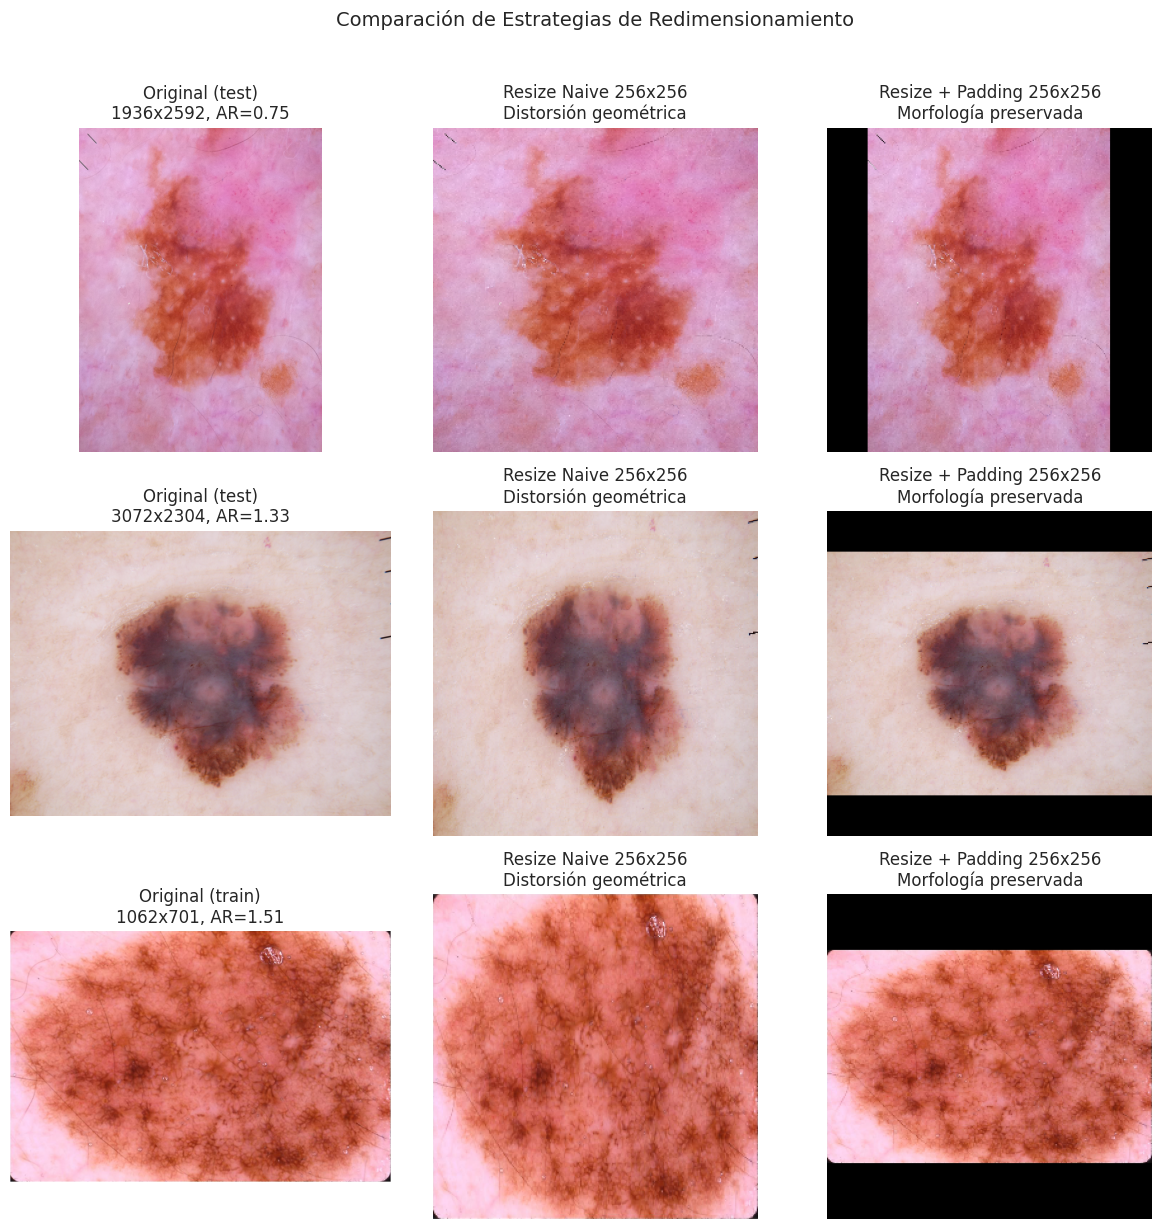

In [9]:
# Visualización del impacto del redimensionamiento: naive vs preservando aspect ratio
def demonstrate_resize_strategies(image_path, target_size=256):
    """Demuestra el impacto de diferentes estrategias de redimensionamiento"""
    
    img = cv2.imread(str(image_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    aspect_ratio = w / h
    
    # Estrategia 1: Resize naive (distorsiona)
    naive_resize = cv2.resize(img, (target_size, target_size))
    
    # Estrategia 2: Resize preservando aspect ratio + padding
    if w > h:
        new_w = target_size
        new_h = int(target_size / aspect_ratio)
    else:
        new_h = target_size
        new_w = int(target_size * aspect_ratio)
    
    resized = cv2.resize(img, (new_w, new_h))
    
    # Padding centrado
    pad_h = (target_size - new_h) // 2
    pad_w = (target_size - new_w) // 2
    padded = np.zeros((target_size, target_size, 3), dtype=np.uint8)
    padded[pad_h:pad_h+new_h, pad_w:pad_w+new_w] = resized
    
    return img, naive_resize, padded, aspect_ratio

# Seleccionar imágenes con diferentes aspect ratios
sample_images = []
for name, stats in all_stats.items():
    if stats["heights"]:
        paths = DATASETS[name]
        images = list(paths['images'].glob("*.jpg"))
        if images:
            # Buscar imágenes con aspect ratios extremos
            for img_path in images[:50]:
                img = cv2.imread(str(img_path))
                if img is not None:
                    h, w = img.shape[:2]
                    ar = w / h
                    sample_images.append((img_path, ar, name))

# Ordenar por aspect ratio y tomar ejemplos extremos
sample_images.sort(key=lambda x: x[1])
examples = [sample_images[0], sample_images[len(sample_images)//2], sample_images[-1]]

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle("Comparación de Estrategias de Redimensionamiento", fontsize=14, y=1.02)

for i, (img_path, ar, dataset) in enumerate(examples):
    original, naive, padded, aspect_ratio = demonstrate_resize_strategies(img_path)
    
    axes[i, 0].imshow(original)
    axes[i, 0].set_title(f"Original ({dataset})\n{original.shape[1]}x{original.shape[0]}, AR={aspect_ratio:.2f}")
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(naive)
    axes[i, 1].set_title(f"Resize Naive 256x256\nDistorsión geométrica")
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(padded)
    axes[i, 2].set_title(f"Resize + Padding 256x256\nMorfología preservada")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()


In [10]:
# Figura 2: Intensidad de píxeles y cobertura
fig2 = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Intensidad Media de Píxeles", "Cobertura de Máscaras"),
    specs=[[{"type": "box"}, {"type": "box"}]]
)

# Intensidad de píxeles
intensity_data = []
labels = []
for name, stats in all_stats.items():
    if stats["pixel_intensity_means"]:
        intensity_data.append(stats["pixel_intensity_means"])
        labels.append(name.upper())

fig2.add_trace(go.Box(y=intensity_data[0], name=labels[0], marker_color=colors['train']), row=1, col=1)
if len(intensity_data) > 1:
    fig2.add_trace(go.Box(y=intensity_data[1], name=labels[1], marker_color=colors['val']), row=1, col=1)
if len(intensity_data) > 2:
    fig2.add_trace(go.Box(y=intensity_data[2], name=labels[2], marker_color=colors['test']), row=1, col=1)

# Cobertura de máscaras (solo train y val)
coverage_data = []
coverage_labels = []
for name in ['train', 'val', 'test']:
    if all_stats[name]["mask_coverage"]:
        coverage_data.append(all_stats[name]["mask_coverage"])
        coverage_labels.append(name.upper())

if coverage_data:
    fig2.add_trace(go.Box(y=coverage_data[0], name=coverage_labels[0], 
                         marker_color=colors['train']), row=1, col=2)
    if len(coverage_data) > 1:
        fig2.add_trace(go.Box(y=coverage_data[1], name=coverage_labels[1], 
                             marker_color=colors['val']), row=1, col=2)
    if len(coverage_data) > 2:
        fig2.add_trace(go.Box(y=coverage_data[2], name=coverage_labels[2], 
                             marker_color=colors['test']), row=1, col=2)

fig2.update_layout(title_text="Comparación de Características de Imágenes", height=500)
fig2.show()

In [11]:
def check_image_mask_correspondence(images_dir, masks_dir):
    """Verifica que cada imagen tenga su máscara correspondiente"""
    
    image_files = sorted([f.stem for f in images_dir.glob("*.jpg")])
    mask_files = sorted([f.stem.replace('_segmentation', '') for f in masks_dir.glob("*.png")])
    
    missing_masks = set(image_files) - set(mask_files)
    extra_masks = set(mask_files) - set(image_files)
    
    return {
        "total_images": len(image_files),
        "total_masks": len(mask_files),
        "missing_masks": len(missing_masks),
        "extra_masks": len(extra_masks),
        "perfect_match": len(missing_masks) == 0 and len(extra_masks) == 0
    }

In [12]:
print("Verificando correspondencia imagen-máscara...")
correspondence_results = {}

for name in ['train', 'val', 'test']:
    if DATASETS[name]['masks']:
        result = check_image_mask_correspondence(
            DATASETS[name]['images'], 
            DATASETS[name]['masks']
        )
        correspondence_results[name] = result
        
        print(f"\n{name.upper()}:")
        print(f"  Imágenes: {result['total_images']}")
        print(f"  Máscaras: {result['total_masks']}")

Verificando correspondencia imagen-máscara...

TRAIN:
  Imágenes: 2594
  Máscaras: 2594

VAL:
  Imágenes: 100
  Máscaras: 100

TEST:
  Imágenes: 1000
  Máscaras: 1000


## 4. VISUALIZACIÓN DE MUESTRAS POR CONJUNTO

In [13]:
def visualize_dataset_samples(dataset_name, n_samples=4):
    """Visualiza muestras aleatorias de un conjunto"""
    
    paths = DATASETS[dataset_name]
    image_files = list(paths['images'].glob("*.jpg"))
    
    if len(image_files) == 0:
        print(f"No hay imágenes en {dataset_name}")
        return
    
    samples = np.random.choice(image_files, min(n_samples, len(image_files)), replace=False)
    
    fig, axes = plt.subplots(2, n_samples, figsize=(4*n_samples, 8))
    fig.suptitle(f"Dataset: {dataset_name.upper()}", fontsize=16, y=1.02)
    
    for i, img_path in enumerate(samples):
        # Cargar imagen
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Mostrar imagen
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"ID: {img_path.stem[:12]}...")
        axes[0, i].axis('off')
        
        # Mostrar máscara si existe
        if paths['masks']:
            mask_path = paths['masks'] / f"{img_path.stem}_segmentation.png"
            if mask_path.exists():
                mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
                axes[1, i].imshow(mask, cmap='gray')
                axes[1, i].set_title(f"Máscara")
                
                # Superposición
                mask_rgb = np.zeros_like(img)
                mask_rgb[:,:,1] = mask
                overlay = cv2.addWeighted(img, 0.7, mask_rgb, 0.3, 0)
                # Podríamos mostrar la superposición en una tercera fila si se desea
            else:
                axes[1, i].text(0.5, 0.5, "Sin máscara", 
                              ha='center', va='center', fontsize=12)
                axes[1, i].set_title("Máscara no encontrada")
        else:
            axes[1, i].text(0.5, 0.5, "Dataset sin máscaras", 
                          ha='center', va='center', fontsize=10)
            axes[1, i].set_title("Test set")
        
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

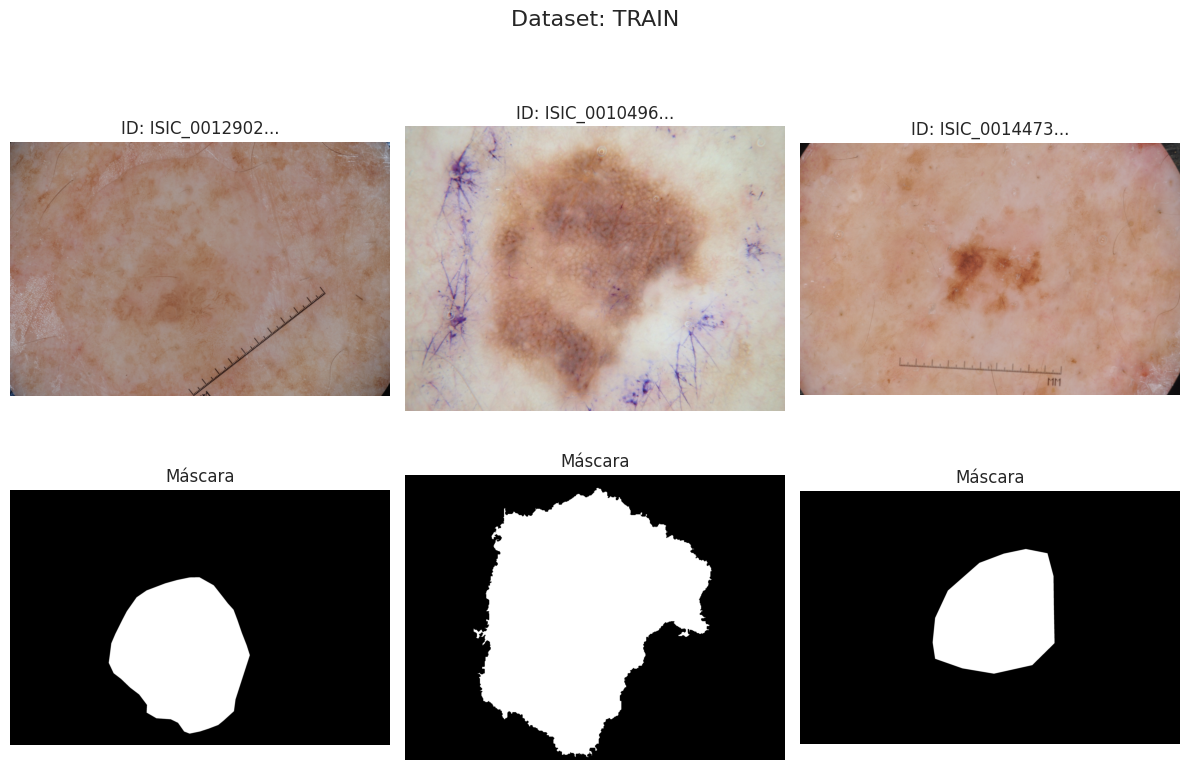

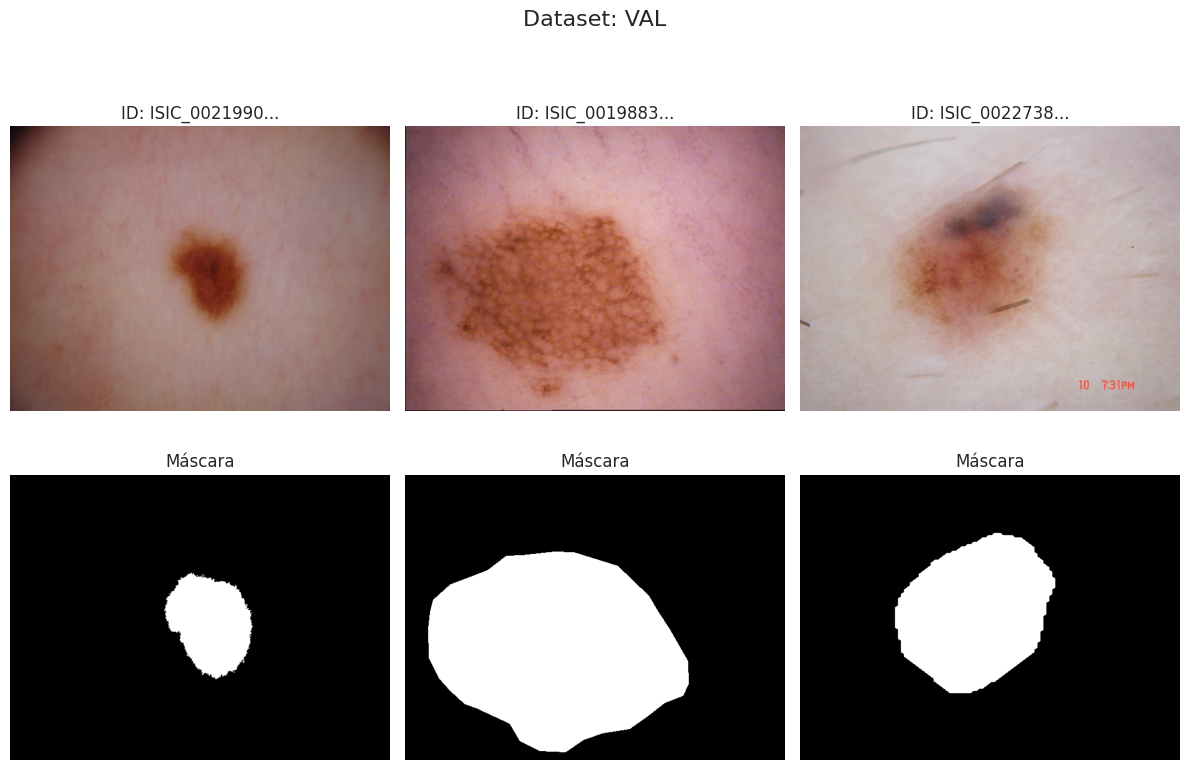

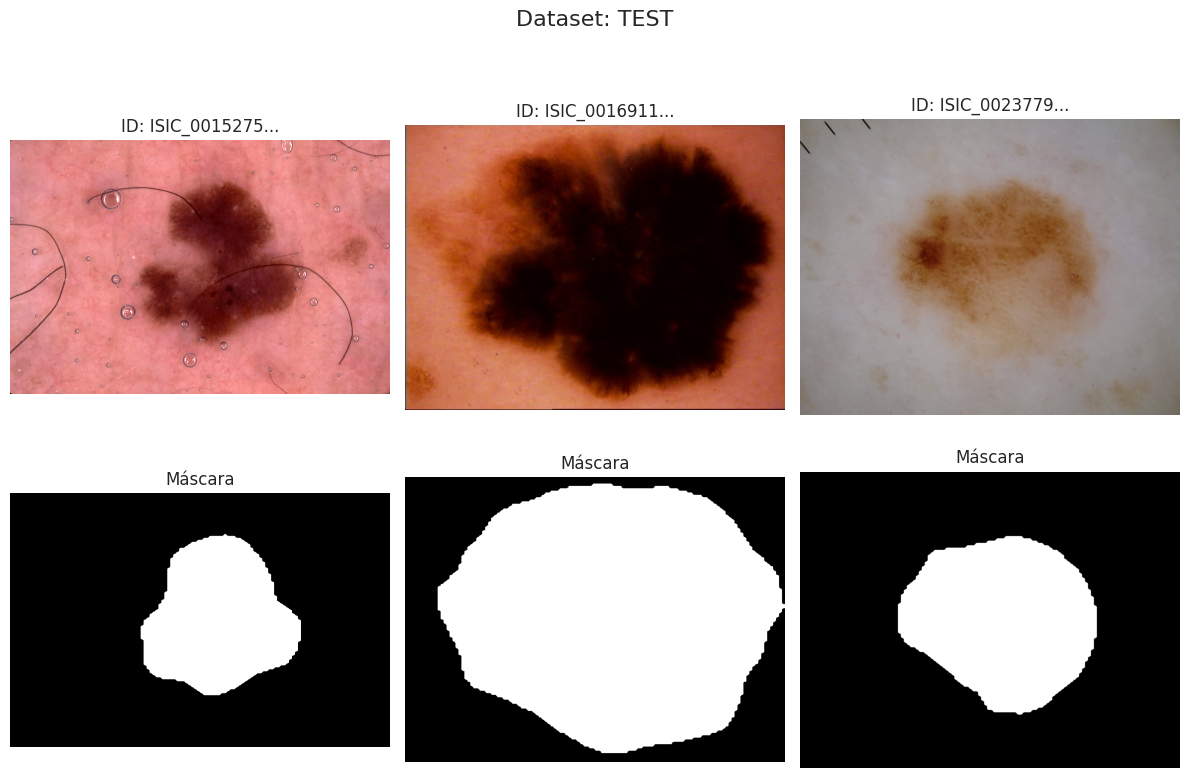

In [14]:
# Visualizar muestras de cada conjunto
for dataset_name in DATASETS.keys():
    visualize_dataset_samples(dataset_name, n_samples=3)

## 5. ANÁLISIS DE CALIDAD DE MÁSCARAS

In [15]:
def analyze_mask_quality(masks_dir, sample_size=50):
    """Analiza la calidad de las máscaras"""
    
    mask_files = list(masks_dir.glob("*.png"))
    if len(mask_files) == 0:
        return None
    
    if sample_size > len(mask_files):
        sample_files = mask_files
    else:
        sample_files = np.random.choice(mask_files, sample_size, replace=False)
    
    qualities = []
    
    for mask_path in sample_files:
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        
        # Normalizar
        mask_binary = (mask > 0).astype(np.uint8)
        
        # Calcular bordes (para ver suavidad)
        edges = cv2.Canny(mask_binary, 0, 1)
        edge_density = edges.sum() / mask.size
        
        # Calcular compacidad (perímetro^2 / área)
        contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            area = cv2.contourArea(contours[0])
            perimeter = cv2.arcLength(contours[0], True)
            compactness = (perimeter ** 2) / (4 * np.pi * area) if area > 0 else 0
        else:
            compactness = 0
        
        qualities.append({
            "edge_density": edge_density,
            "compactness": compactness,
            "area": mask_binary.sum() / 255
        })
    
    return pd.DataFrame(qualities)


Calidad de máscaras - TRAIN:
  Densidad de bordes media: 0.3891
  Compacidad media: 6.17
  Área media: 6503 píxeles


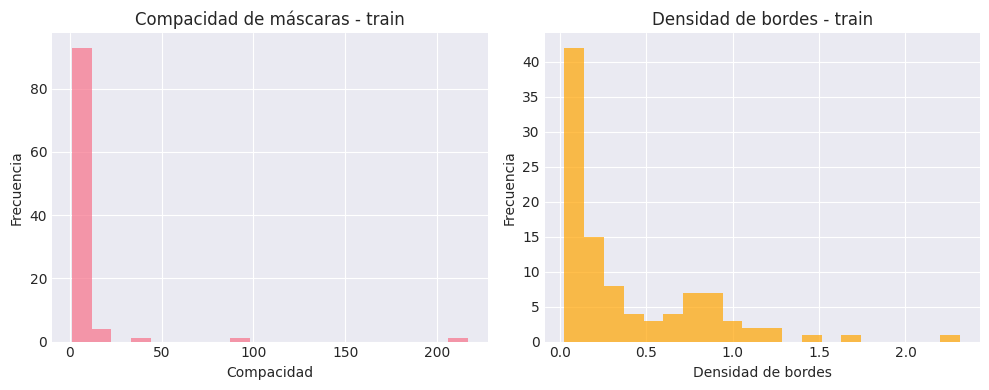


Calidad de máscaras - VAL:
  Densidad de bordes media: 0.4649
  Compacidad media: 2.21
  Área media: 6217 píxeles


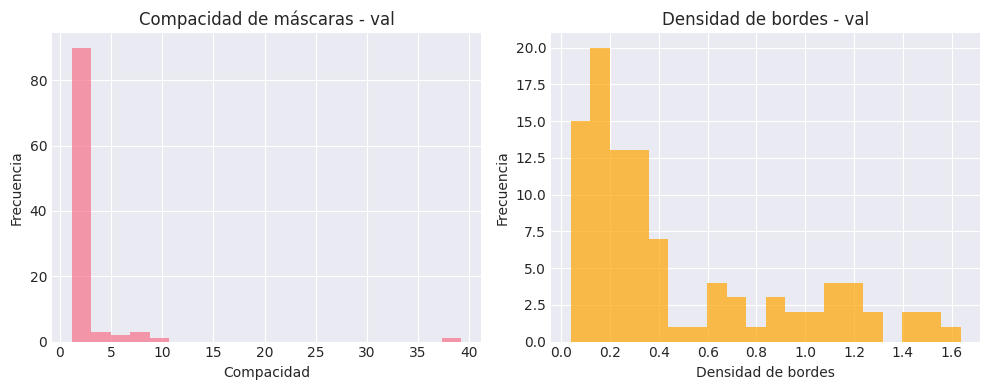


Calidad de máscaras - TEST:
  Densidad de bordes media: 0.4577
  Compacidad media: 2.75
  Área media: 7624 píxeles


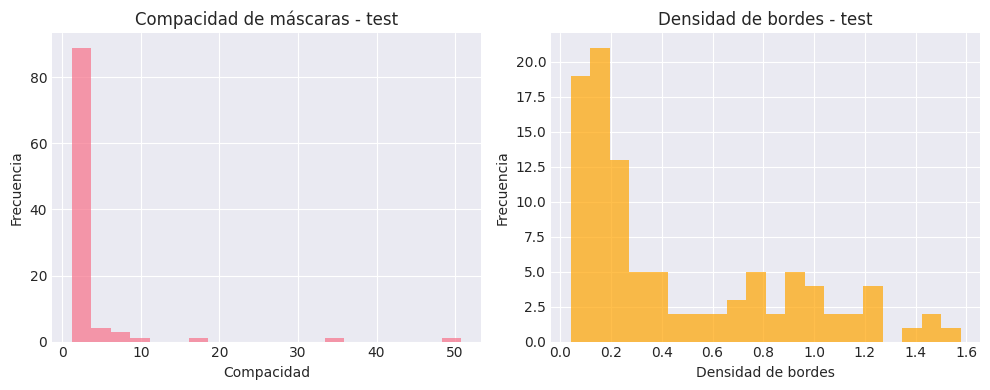

In [16]:
# Analizar calidad de máscaras en train y val
for name in ['train', 'val', 'test']:
    if DATASETS[name]['masks']:
        quality_df = analyze_mask_quality(DATASETS[name]['masks'], sample_size=100)
        
        print(f"\nCalidad de máscaras - {name.upper()}:")
        print(f"  Densidad de bordes media: {quality_df['edge_density'].mean():.4f}")
        print(f"  Compacidad media: {quality_df['compactness'].mean():.2f}")
        print(f"  Área media: {quality_df['area'].mean():.0f} píxeles")
        
        # Histograma de compacidad
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.hist(quality_df['compactness'], bins=20, alpha=0.7)
        plt.xlabel('Compacidad')
        plt.ylabel('Frecuencia')
        plt.title(f'Compacidad de máscaras - {name}')
        
        plt.subplot(1, 2, 2)
        plt.hist(quality_df['edge_density'], bins=20, alpha=0.7, color='orange')
        plt.xlabel('Densidad de bordes')
        plt.ylabel('Frecuencia')
        plt.title(f'Densidad de bordes - {name}')
        
        plt.tight_layout()
        plt.show()

## 6. CÁLCULO DE ESTADÍSTICAS DE NORMALIZACIÓN

Calculamos la media y desviación estándar por canal del conjunto de entrenamiento para usar normalización específica del dataset ISIC en lugar de ImageNet.

In [17]:
def calculate_dataset_normalization_stats(images_dir: Path, use_processed: bool = True):
    """
    Calcula la media y desviación estándar por canal del dataset.
    
    Args:
        images_dir: Directorio con las imágenes
        use_processed: Si las imágenes son .npy procesadas o .jpg raw
        
    Returns:
        dict con mean y std por canal (RGB)
    """
    if use_processed:
        image_files = list(images_dir.glob("*.npy"))
    else:
        image_files = list(images_dir.glob("*.jpg"))
    
    print(f"Calculando estadísticas de {len(image_files)} imágenes...")
    
    # Acumuladores para cálculo online (evita cargar todo en memoria)
    n_pixels = 0
    channel_sum = np.zeros(3, dtype=np.float64)
    channel_sum_sq = np.zeros(3, dtype=np.float64)
    
    for i, img_path in enumerate(image_files):
        # Cargar imagen
        if use_processed:
            image = np.load(img_path)
            # Si está en rango [0, 255], normalizar a [0, 1]
            if image.max() > 1.0:
                image = image / 255.0
        else:
            image = cv2.imread(str(img_path))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) / 255.0
        
        # Reshape a (N_pixels, 3)
        pixels = image.reshape(-1, 3).astype(np.float64)
        
        # Acumular estadísticas
        n_pixels += pixels.shape[0]
        channel_sum += pixels.sum(axis=0)
        channel_sum_sq += (pixels ** 2).sum(axis=0)
        
        if (i + 1) % 500 == 0:
            print(f"  Procesadas {i + 1}/{len(image_files)}...")
    
    # Calcular media y std
    mean = channel_sum / n_pixels
    variance = (channel_sum_sq / n_pixels) - (mean ** 2)
    std = np.sqrt(variance)
    
    return {
        "mean": mean.tolist(),
        "std": std.tolist(),
        "n_images": len(image_files),
        "n_pixels": n_pixels
    }

In [18]:
# Calcular estadísticas del conjunto de entrenamiento (procesado)
PROCESSED_TRAIN_PATH = Path("../data/processed/train/images")

if PROCESSED_TRAIN_PATH.exists():
    isic_stats = calculate_dataset_normalization_stats(PROCESSED_TRAIN_PATH, use_processed=True)
    
    print("\n" + "="*60)
    print("ESTADÍSTICAS DE NORMALIZACIÓN - ISIC 2018 TRAINING SET")
    print("="*60)
    print(f"\nMean (RGB): [{isic_stats['mean'][0]:.4f}, {isic_stats['mean'][1]:.4f}, {isic_stats['mean'][2]:.4f}]")
    print(f"Std (RGB):  [{isic_stats['std'][0]:.4f}, {isic_stats['std'][1]:.4f}, {isic_stats['std'][2]:.4f}]")
    print(f"\nCalculado de {isic_stats['n_images']:,} imágenes ({isic_stats['n_pixels']:,} píxeles)")
    
    # Comparación con ImageNet
    print("\n" + "-"*60)
    print("COMPARACIÓN CON IMAGENET:")
    print("-"*60)
    imagenet_mean = [0.485, 0.456, 0.406]
    imagenet_std = [0.229, 0.224, 0.225]
    
    print(f"{'Canal':<10} {'ISIC Mean':<12} {'ImageNet Mean':<15} {'Diferencia':<12}")
    for i, c in enumerate(['R', 'G', 'B']):
        diff = isic_stats['mean'][i] - imagenet_mean[i]
        print(f"{c:<10} {isic_stats['mean'][i]:<12.4f} {imagenet_mean[i]:<15.4f} {diff:+.4f}")
    
    print(f"\n{'Canal':<10} {'ISIC Std':<12} {'ImageNet Std':<15} {'Diferencia':<12}")
    for i, c in enumerate(['R', 'G', 'B']):
        diff = isic_stats['std'][i] - imagenet_std[i]
        print(f"{c:<10} {isic_stats['std'][i]:<12.4f} {imagenet_std[i]:<15.4f} {diff:+.4f}")
else:
    print("Directorio de datos procesados no encontrado.")
    print("Ejecuta primero el preprocesamiento de datos.")

Calculando estadísticas de 2594 imágenes...
  Procesadas 500/2594...
  Procesadas 1000/2594...
  Procesadas 1500/2594...
  Procesadas 2000/2594...
  Procesadas 2500/2594...

ESTADÍSTICAS DE NORMALIZACIÓN - ISIC 2018 TRAINING SET

Mean (RGB): [0.4963, 0.4088, 0.3765]
Std (RGB):  [0.3505, 0.3015, 0.2895]

Calculado de 2,594 imágenes (170,000,384 píxeles)

------------------------------------------------------------
COMPARACIÓN CON IMAGENET:
------------------------------------------------------------
Canal      ISIC Mean    ImageNet Mean   Diferencia  
R          0.4963       0.4850          +0.0113
G          0.4088       0.4560          -0.0472
B          0.3765       0.4060          -0.0295

Canal      ISIC Std     ImageNet Std    Diferencia  
R          0.3505       0.2290          +0.1215
G          0.3015       0.2240          +0.0775
B          0.2895       0.2250          +0.0645


## 7. EXPORTAR RESULTADOS DEL EDA

In [19]:
# Crear directorio para resultados del EDA
eda_results_dir = Path("./experiments/eda_results")
eda_results_dir.mkdir(parents=True, exist_ok=True)

# Guardar DataFrames
df_comparison.to_csv(eda_results_dir / "dataset_comparison.csv", index=False)

# Guardar estadísticas detalladas
import json
with open(eda_results_dir / "detailed_stats.json", "w") as f:
    # Convertir a tipos nativos de Python para JSON
    json_stats = {}
    for name, stats in all_stats.items():
        json_stats[name] = {
            k: (v if not isinstance(v, (np.ndarray, list)) else 
                [float(x) for x in v] if isinstance(v, np.ndarray) else v)
            for k, v in stats.items()
        }
    json.dump(json_stats, f, indent=2)

# Guardar estadísticas de normalización ISIC
if 'isic_stats' in dir():
    with open(eda_results_dir / "isic_normalization_stats.json", "w") as f:
        json.dump({
            "isic_2018": isic_stats,
            "imagenet": {
                "mean": [0.485, 0.456, 0.406],
                "std": [0.229, 0.224, 0.225]
            },
            "description": "Estadísticas calculadas del training set de ISIC 2018"
        }, f, indent=2)
    print("Estadísticas de normalización ISIC guardadas")

print(f"\nResultados guardados en: {eda_results_dir.absolute()}")

Estadísticas de normalización ISIC guardadas

Resultados guardados en: /home/salvalago23/tfm_segmentacion/notebooks/experiments/eda_results
